# Figure 6: Denoising with Posterior Analysis

In [1]:
import os
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [3]:
param_file = 'params_mnist_-1_8_infoGAN_AE_v2_full_sigma'

PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

In [4]:
params   = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [5]:
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [6]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'nsf2')

In [8]:
from pae.load_data import load_mnist

load_func                                         = load_mnist
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid
    
def add_noise(x,sigma=0.1):
    nn = np.random.normal(size=np.shape(x))
    x  = x+nn*sigma
    return x

x_train    = add_noise(x_train)/255.-0.5
x_test     = add_noise(x_test)/255.-0.5
x_valid    = add_noise(x_valid)/255.-0.5

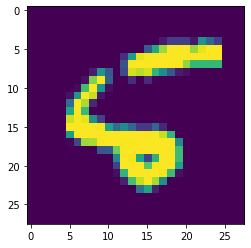

In [36]:
for ii in [8]:
    plt.imshow(x_test[ii,:,:,0])
    plt.show()

In [37]:
data_dim    = 28*28
data_size   = params['batch_size']
sigma_n     = (params['full_sigma']+1e-4).reshape((1,28*28,1)).astype(np.float32)
noise_n     = sigma_n
hidden_size = params['latent_size']
n_channels  = 1
seed        = 777


# settings for reconstruction with uncorrupted data
# corr_type   = 'none'
# num_mnist   = 6
# label       = 'uncorrupted'
# noise_level = 0.0
# num_comp    = 2

# settings for reconstrcution with rectangular mask
# corr_type   = 'mask'
# num_mnist   = 32
# label       = 'solidmask'
# noise_level = 0.0
# num_comp    = 32

#settings for reconstruction with sparse mask 
# corr_type   = 'sparse mask'
# num_mnist   = 1
# label       = 'sparse95'
# noise_level = 0.
# num_comp    = 2

# settings for reconstruction with noise
corr_type   = 'noise'
num_mnist   = 8
label       = 'noise12'
noise_level = 1.2
params['plot_dir']   = os.path.join(PROJECT_PATH,'plots',label+'_'+str(num_mnist))

# settings for reconstruction with noise and mask
# corr_type   = 'noise+mask'
# num_mnist   = 6
# label       = 'masknoise05'
# noise_level = 0.5
# num_comp    = 2

In [38]:
def plot_image(image, save=True, directory='./plots/',filename='plotted_image', title='image',vmin=None,vmax=None, mask=None):
  
  if np.any(mask==None):
    mask=np.ones((28,28))
  mask = np.reshape(mask,(28,28))
  plt.figure()
  #plt.title(title)
  plt.imshow((image).reshape((28,28))*mask,cmap='gray',vmin=vmin, vmax=vmax)
  plt.axis('off')
  #plt.colorbar()
  if save: 
    plt.savefig(directory+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  return True

def get_custom_noise(shape, signal_dependent=False, signal =None, sigma_low=0.07, sigma_high=0.22, threshold=0.02 ):
  
  sigma = sigma_n
  
  if signal_dependent: 
    for ii in range(data_size):
      sigma[ii][np.where(signal[ii]<=threshold)]= sigma_low
      sigma[ii][np.where(signal[ii]>threshold)]= sigma_high
      
  data_noise = np.ones_like(sigma)*noise_level
  
  sigma = np.sqrt(sigma**2+data_noise**2)
  
  return sigma
  

def make_corrupted_data(x_true, corr_type='mask'):
  
  mask = np.ones((28,28))
  
  if corr_type=='mask':
    
    minx = 0
    maxx = 18
    
    mask[0:28,minx:maxx]=0.
    
    corr_data = x_true*mask[None,:,:,None]
    
  elif corr_type=='sparse mask':
    
    mask    = np.ones(data_dim, dtype=int)
    percent = 95
    np.random.seed(seed+2)
    indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
    print('precentage masked:', len(indices)/data_dim)
    mask[indices] =0 
  
    corr_data = x_true*mask[None,:,:]
    
  elif corr_type=='noise':
    
    np.random.seed(seed+2)
    noise = np.reshape(np.random.randn((data_size*data_dim))*noise_level,((data_size,28,28)))
    print(x_true.shape)
    corr_data = np.reshape(np.squeeze(x_true)+noise,(data_size,28,28))
    
  elif corr_type=='noise+mask':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    minx = 14
    maxx = 28
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28,28))
    
    corr_data = x_true+noise
    corr_data = corr_data*mask[None,:,:]
    
  elif corr_type=='none':
    
    corr_data = x_true
    
  corr_data = np.expand_dims(corr_data,-1)
  
  mask = mask.flatten()
  
  return corr_data, mask

In [39]:
def fwd_pass(generator,nvp,z,mask):
  
  fwd_z           = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z},as_dict=True)['fwd_pass']
  fwd_z           = generator({'z':z},as_dict=True)['x']
  gen_z           = tf.boolean_mask(tf.reshape(fwd_z,[data_size,data_dim,n_channels]),mask, axis=1)

  return gen_z


def get_likelihood(generator,nvp,z,sigma,mask):
  
  gen_z           = fwd_pass(generator,nvp,z,mask)
  
  sigma           = tf.boolean_mask(sigma,mask, axis=1)

  likelihood      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma))

  return likelihood

def get_prior():
  
  return tfd.MultivariateNormalDiag(tf.zeros([data_size,hidden_size]), scale_identity_multiplier=1.0, name ='prior')

def get_log_posterior(z,x,generator,nvp,sigma,mask, beta):
  
  likelihood      = get_likelihood(generator,nvp,z,sigma,mask)
  
  prior           = get_prior()
  
  masked_x        = tf.boolean_mask(x,mask, axis=1)
  
  log_posterior   = prior.log_prob(z)+likelihood.log_prob(masked_x)*beta
  
  return log_posterior


def get_recon(generator,nvp, z,sigma,mask):
  
  prob = get_likelihood(generator,nvp, z,sigma,mask)
  
  recon= prob.mean()
  
  return recon

def get_hessian(func, z):
  
  hess             = tf.hessians(func,z)
  hess             = tf.gather(hess, 0)
  
  return(tf.reduce_sum(hess, axis = 2 ))


def get_GN_hessian(generator,nvp,z,mask,sigma):


  gen_z            = fwd_pass(generator,nvp,z,mask)
  
  sigma            = tf.boolean_mask(sigma,mask, axis=1)

  grad_g           = tf.gather(tf.gradients(gen_z/(sigma),z),0)

  grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

  one              = tf.linalg.eye(hidden_size, batch_shape=[data_size],dtype=tf.float32)

  hess_GN          = one+grad_g2
  
  return hess_GN
  
def compute_covariance(hessian):
  
  hessian = transform_diagonal(hessian, None, 1e-4)
  cov = tf.linalg.inv(hessian)
  
  cov = (cov+tf.linalg.transpose(cov))*0.5
  
  return cov

In [40]:
def minimize_posterior(initial_value, x, custom_mask, noise, my_sess, annealing =True):
  
  ini = np.reshape(initial_value,[data_size,hidden_size])
  
  my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:ini, mask:custom_mask,sigma_corr:noise})
  
  pos_def = False

  
  posterior_loss = []
  for lrate, numiter in zip([1e-1,1e-2,1e-3,1e-4],[10000,10000,10000,10000]):
    print('lrate', lrate)
    for jj in range(numiter):
      if annealing and lrate==1e-1:
        inv_T= np.round(0.5*np.exp(-(1.-jj/numiter)),decimals=1)
      else:
        inv_T= 1.
      _, ll = my_sess.run([opt_op_MAP,loss_MAP],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate, inverse_T:inv_T})
      posterior_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll,r'inverse T', inv_T)
        
  z_value = my_sess.run(MAP,feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise})
  
  eig     = my_sess.run(tf.linalg.eigvalsh(hessian[0]),feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  hess    = my_sess.run(hessian[0],feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  hessGN  = my_sess.run(hessian_GN[0],feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  print('eig', eig)
  if np.all(eig>0.):
    pos_def = True
  
  loss    = ll
  plt.figure()
  plt.plot(posterior_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return z_value, loss, pos_def, hess, hessGN
  

In [41]:
def get_laplace_sample(num,map_value,x,mymask,noise,my_sess):
  
  my_sess.run(MAP_reset,feed_dict={MAP_ini:map_value})
  my_sess.run(update_mu)
  my_sess.run(update_TriL,feed_dict={input_data: x, mask: mymask, sigma_corr:noise})
  
  samples=[]
  for ii in range(num):
    my_sess.run(posterior_sample,feed_dict={input_data: x, sigma_corr:noise})
    samples.append(my_sess.run(recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

def get_gmm_sample(num,x,mymask,noise,my_sess):
  
  samples=[]
  for ii in range(num):
    samples.append(my_sess.run(gmm_recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

In [42]:
def plot_samples(samples, mask, title='samples', filename='samples'):
  plt.figure()
  plt.title(title)
  for i in range(min(len(samples),16)):
      subplot(4,4,i+1)
      imshow(np.reshape(samples[i,:],(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
      axis('off')
  plt.savefig(plot_path+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    plt.figure()
    plt.title('masked'+title)
    for i in range(min(len(samples),16)):
        subplot(4,4,i+1)
        imshow(np.reshape(samples[i,0,:,0]*mask,(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
        axis('off')     
    plt.savefig(plot_path+filename+'masked.pdf',bbox_inches='tight')
    plt.show()

In [43]:
def get_random_start_values(num, my_sess):
  result=[]
  for ii in range(num):
    result.append(my_sess.run(get_prior().sample()))
  return result

In [44]:
def get_chi2(sigma,data,mean,masking=True, mask=None,threshold=0.02):
  
  if masking:
    mask = np.reshape(mask,data.shape)
    data = data[np.where(mask==1)]
    mean = mean[np.where(mask==1)]
    sigma= sigma[np.where(mask==1)]
    
  
  low = min(sigma.flatten())
  high= max(sigma.flatten())
  
  chi2_tot = np.sum((data-mean)**2/sigma**2)
  dof_tot  = len(np.squeeze(data))
  
  if corr_type not in ['noise','noise+mask']:
    chi2_low = np.sum((data[np.where(data<=threshold)]-mean[np.where(data<=threshold)])**2/sigma[np.where(data<=threshold)]**2)
    dof_low  = len(np.squeeze(data[np.where(data<=threshold)]))
    chi2_high= np.sum((data[np.where(data>threshold)]-mean[np.where(data>threshold)])**2/sigma[np.where(data>threshold)]**2)
    dof_high = len(np.squeeze(data[np.where(data>threshold)]))
  else:
    chi2_low = None
    dof_low  = None
    chi2_high= None
    dof_high = None
  
  return chi2_tot, dof_tot, chi2_low, dof_low, chi2_high, dof_high, masking

In [45]:
def plot_minima(minima, losses, var):

  plt.figure()
  plt.title('Minimization result')
  plt.plot(np.arange(len(losses)),losses,ls='',marker='o')
  plt.xlabel('# iteration')
  plt.ylabel('loss')
  plt.savefig(plot_path+'minimzation_results_%s.pdf'%(label),bbox_inches='tight')
  plt.show()
  
  colors = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
  cmap   = matplotlib.cm.get_cmap('Spectral')
  
  var = np.squeeze(var)
  plt.figure()
  plt.title('value of hidden variables at minima')
  for ii in range(len(minima)):
  
    yerr_= np.sqrt(var[ii])

    plt.errorbar(np.arange(hidden_size),np.squeeze(minima)[ii], marker='o',ls='', c=cmap(colors(losses[ii])), mew=0, yerr=yerr_, label ='%d'%losses[ii])
  plt.legend(ncol=4, loc=(1.01,0))
  plt.xlabel('# hidden variable')
  plt.ylabel('value')
  plt.savefig(plot_path+'hidden_values_at_minima_%s.pdf'%(label),bbox_inches='tight')
  plt.show()

In [47]:
def get_gmm_parameters(minima, x, noise, mymask, offset):
  mu   =[]
  w    =[]
  sigma=[]
  print(len(minima), num_comp)
  for ii in range(num_comp):

    # do Laplace approximation around this minimum
    mu+=[minima[ii][0]]

    sess.run(MAP_reset,feed_dict={MAP_ini:minima[ii]})
    sigma+=[sess.run(update_TriL,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})]

    # correct weighting of different minima according to El20 procedure, with samples at the maxima and well seperated maxima
    logdet  = sess.run(tf.linalg.logdet(covariance[0]),feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    logprob = sess.run(nlPost_MAP,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    w+=[np.exp(0.5*logdet+logprob+offset)]
  print(np.asarray(w).shape)
  print('weights of Gaussian mixtures:', np.asarray(w)[:,0]/np.sum(np.asarray(w)[:,0]))
  mu     = np.reshape(np.asarray(mu),[1,num_comp,hidden_size])
  sigma  = np.reshape(np.asarray(sigma)[:,0],[1,num_comp,hidden_size,hidden_size])
  w      = np.squeeze(np.asarray(w)[:,0])
                         
  return mu, sigma, w
                                 

In [48]:
def plot_prob_2D_GMM(samples, indices):

    samples = samples[:,0,:]

    samples = np.hstack((np.expand_dims(samples[:,indices[0]],-1),np.expand_dims(samples[:,indices[1]],-1)))

    figure=corner.corner(samples)
    axes = np.array(figure.axes).reshape((2, 2))

    axes[1,0].set_xlabel('latent space variable %d'%indices[0])
    axes[1,0].set_ylabel('latent space variable %d'%indices[1])
    plt.savefig(plot_path+'posterior_contour_GMM_%s_latent_space_dir_%d_%d.pdf'%(label,indices[0],indices[1]),bbox_inches='tight')
    plt.show()
    
  

In [49]:
def transform_diagonal(matrix, transform=tf.nn.softplus, add=0):
  diag = tf.linalg.diag_part(matrix)
  if transform is not None:
    diag = transform(diag)
  transformed_diag = diag+add
  new_matrix = tf.linalg.set_diag(matrix, transformed_diag)
  return new_matrix

In [ ]:
tf.reset_default_graph()


sigma_corr  = tf.placeholder_with_default(noise_n,shape=[1,data_dim,n_channels])
mask        = tf.placeholder_with_default(np.ones([data_dim], dtype='float32'),shape=[data_dim])
input_data  = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)

inverse_T   = tf.placeholder_with_default(1., shape=[])
lr          = tf.placeholder_with_default(0.001,shape=[])

encoder     = hub.Module(encoder_path, trainable=False)
generator   = hub.Module(generator_path, trainable=False)
nvp_funcs   = hub.Module(nvp_path, trainable=False)

MAP_ini     = tf.placeholder_with_default(tf.zeros([data_size,hidden_size]),shape=[data_size,hidden_size])
MAP         = tf.Variable(MAP_ini)
MAP_reset   = tf.stop_gradient(MAP.assign(MAP_ini))

nlPost_MAP  = get_log_posterior(MAP, input_data, generator,nvp_funcs, sigma_corr,mask, inverse_T)
loss_MAP    = -nlPost_MAP[0]

optimizer   = tf.train.AdamOptimizer(learning_rate=lr)

opt_op_MAP  = optimizer.minimize(loss_MAP, var_list=[MAP])

recon_MAP   = get_recon(generator,nvp_funcs, MAP,sigma_corr,mask)

hessian            = get_hessian(-nlPost_MAP,MAP)
hessian_GN         = get_GN_hessian(generator,nvp_funcs,MAP,mask,sigma_corr)
covariance         = compute_covariance(hessian)
variance           = tf.linalg.diag_part(covariance)[0]
print(covariance)
# 

# ini_val  = np.ones((1,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
# with tf.variable_scope("Laplace_Posterior",reuse=tf.AUTO_REUSE):
#   mu_new      = tf.Variable(np.ones((1,hidden_size),dtype=np.float32), dtype=np.float32)
#   sigma_new_t = ini_val
#   sigma_new_t = transform_diagonal(tfp.math.fill_triangular(sigma_new_t))   
#   sigma_new_t2 = tf.Variable(sigma_new_t,dtype=tf.float32)
    
# update_mu          = MAP_update.assign(tf.expand_dims(MAP[0],0))

approx_posterior_laplace = tfd.MultivariateNormalFullCovariance(loc=MAP[0],covariance_matrix=covariance[0])



#update_TriL        = TriL_update.assign(tf.expand_dims(tf.linalg.cholesky(covariance[0]),0))

posterior_sample   = approx_posterior_laplace.sample(64)

recon              = get_recon(generator,nvp_funcs, posterior_sample ,sigma_corr,mask)

# ini_val2    = np.ones((1,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((1,num_comp,hidden_size)), dtype=np.float32)
#   sigma_gmm   = tf.Variable(tfp.math.fill_triangular(ini_val2))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
# sigma_gmmt    = transform_diagonal(sigma_gmm)
# w_positive    = tf.math.softplus(w_gmm)
# w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# mu_ini        = tf.placeholder_with_default(tf.zeros([1,num_comp,hidden_size]),shape=[1,num_comp,hidden_size])
# sigma_ini     = tf.placeholder_with_default(tf.ones([1,num_comp,hidden_size, hidden_size]),shape=[1,num_comp,hidden_size, hidden_size])
# w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_w      = tf.stop_gradient(w_gmm.assign(tfp.math.softplus_inverse(w_ini)))
# update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
# update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(transform_diagonal(sigma_ini)))

# gmm_sample    = gmm.sample()
# gmm_sample    = tf.repeat(gmm_sample, params['batch_size'], axis=0)
# # print(gmm_sample)
# gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask)


In [51]:
minima_path = os.path.join('../minimas/',label)
try:
    os.makedirs(minima_path)
except:
    pass

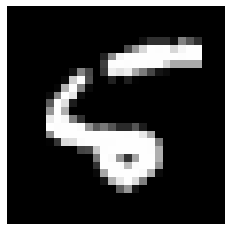

noise (64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)


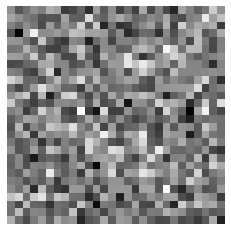

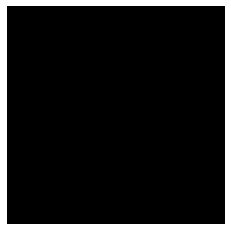

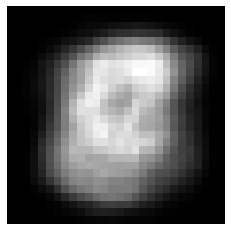

progress in % 0.0
lrate 0.1
iter 0 loss 267.05457 inverse T 0.2
iter 1000 loss 264.4007 inverse T 0.2
iter 2000 loss 264.24213 inverse T 0.2
iter 3000 loss 264.2541 inverse T 0.2
iter 4000 loss 392.0798 inverse T 0.3
iter 5000 loss 392.08273 inverse T 0.3
iter 6000 loss 392.07507 inverse T 0.3
iter 7000 loss 519.91223 inverse T 0.4
iter 8000 loss 519.849 inverse T 0.4
iter 9000 loss 647.62415 inverse T 0.5
lrate 0.01
iter 0 loss 1286.3456 inverse T 1.0
iter 1000 loss 1286.2365 inverse T 1.0
iter 2000 loss 1286.2361 inverse T 1.0
iter 3000 loss 1286.2361 inverse T 1.0
iter 4000 loss 1286.2437 inverse T 1.0
iter 5000 loss 1286.237 inverse T 1.0
iter 6000 loss 1286.2363 inverse T 1.0
iter 7000 loss 1286.2448 inverse T 1.0
iter 8000 loss 1286.2369 inverse T 1.0
iter 9000 loss 1286.239 inverse T 1.0
lrate 0.001
iter 0 loss 1286.2368 inverse T 1.0
iter 1000 loss 1286.2346 inverse T 1.0
iter 2000 loss 1286.2343 inverse T 1.0
iter 3000 loss 1286.2347 inverse T 1.0
iter 4000 loss 1286.2345 inve

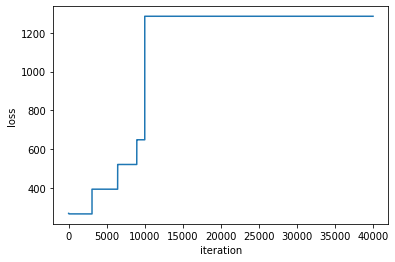

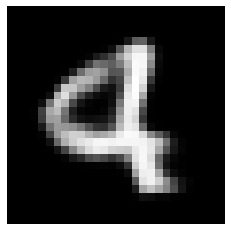

hessian postive definite
progress in % 10.0
lrate 0.1
iter 0 loss 271.66403 inverse T 0.2
iter 1000 loss 263.18658 inverse T 0.2
iter 2000 loss 263.19693 inverse T 0.2
iter 3000 loss 263.2105 inverse T 0.2
iter 4000 loss 390.35583 inverse T 0.3
iter 5000 loss 390.3296 inverse T 0.3
iter 6000 loss 390.3684 inverse T 0.3
iter 7000 loss 517.3986 inverse T 0.4
iter 8000 loss 517.41254 inverse T 0.4
iter 9000 loss 644.5372 inverse T 0.5
lrate 0.01
iter 0 loss 1280.2136 inverse T 1.0
iter 1000 loss 1279.7931 inverse T 1.0
iter 2000 loss 1279.7946 inverse T 1.0
iter 3000 loss 1279.8016 inverse T 1.0
iter 4000 loss 1279.7963 inverse T 1.0
iter 5000 loss 1279.795 inverse T 1.0
iter 6000 loss 1279.795 inverse T 1.0
iter 7000 loss 1279.7926 inverse T 1.0
iter 8000 loss 1279.8009 inverse T 1.0
iter 9000 loss 1279.796 inverse T 1.0
lrate 0.001
iter 0 loss 1279.7938 inverse T 1.0
iter 1000 loss 1279.7917 inverse T 1.0
iter 2000 loss 1279.7921 inverse T 1.0
iter 3000 loss 1279.7924 inverse T 1.0
iter

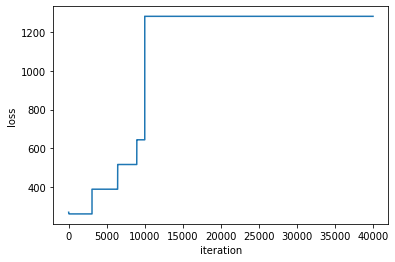

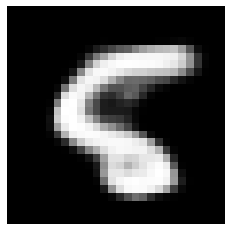

hessian postive definite
progress in % 20.0
lrate 0.1
iter 0 loss 272.63974 inverse T 0.2
iter 1000 loss 263.22046 inverse T 0.2
iter 2000 loss 263.20212 inverse T 0.2
iter 3000 loss 263.20612 inverse T 0.2
iter 4000 loss 390.33466 inverse T 0.3
iter 5000 loss 390.34665 inverse T 0.3
iter 6000 loss 390.34058 inverse T 0.3
iter 7000 loss 517.3952 inverse T 0.4
iter 8000 loss 517.4153 inverse T 0.4
iter 9000 loss 644.4245 inverse T 0.5
lrate 0.01
iter 0 loss 1279.4945 inverse T 1.0
iter 1000 loss 1279.3851 inverse T 1.0
iter 2000 loss 1279.3851 inverse T 1.0
iter 3000 loss 1279.3851 inverse T 1.0
iter 4000 loss 1279.3888 inverse T 1.0
iter 5000 loss 1279.3867 inverse T 1.0
iter 6000 loss 1279.3857 inverse T 1.0
iter 7000 loss 1279.3864 inverse T 1.0
iter 8000 loss 1279.3844 inverse T 1.0
iter 9000 loss 1279.3843 inverse T 1.0
lrate 0.001
iter 0 loss 1279.2703 inverse T 1.0
iter 1000 loss 1279.269 inverse T 1.0
iter 2000 loss 1279.2687 inverse T 1.0
iter 3000 loss 1279.2693 inverse T 1.0


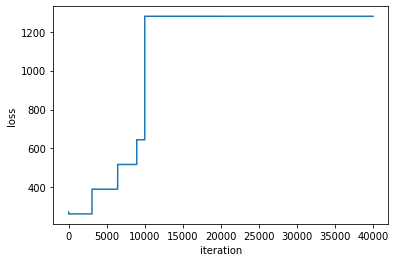

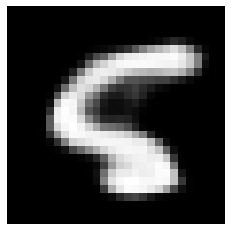

hessian postive definite
progress in % 30.0
lrate 0.1
iter 0 loss 273.86603 inverse T 0.2
iter 1000 loss 263.21655 inverse T 0.2
iter 2000 loss 263.19528 inverse T 0.2
iter 3000 loss 263.20172 inverse T 0.2
iter 4000 loss 390.3561 inverse T 0.3
iter 5000 loss 390.34607 inverse T 0.3
iter 6000 loss 390.30753 inverse T 0.3
iter 7000 loss 517.4605 inverse T 0.4
iter 8000 loss 517.42847 inverse T 0.4
iter 9000 loss 644.53064 inverse T 0.5
lrate 0.01
iter 0 loss 1279.9202 inverse T 1.0
iter 1000 loss 1279.795 inverse T 1.0
iter 2000 loss 1279.7948 inverse T 1.0
iter 3000 loss 1279.7958 inverse T 1.0
iter 4000 loss 1279.8041 inverse T 1.0
iter 5000 loss 1279.7947 inverse T 1.0
iter 6000 loss 1279.7974 inverse T 1.0
iter 7000 loss 1279.8021 inverse T 1.0
iter 8000 loss 1279.7946 inverse T 1.0
iter 9000 loss 1279.7948 inverse T 1.0
lrate 0.001
iter 0 loss 1279.7947 inverse T 1.0
iter 1000 loss 1279.7917 inverse T 1.0
iter 2000 loss 1279.792 inverse T 1.0
iter 3000 loss 1279.792 inverse T 1.0
i

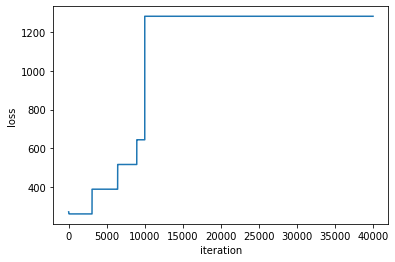

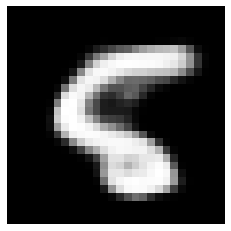

hessian postive definite
progress in % 40.0
lrate 0.1
iter 0 loss 267.02023 inverse T 0.2
iter 1000 loss 263.20325 inverse T 0.2
iter 2000 loss 263.21597 inverse T 0.2
iter 3000 loss 263.2039 inverse T 0.2
iter 4000 loss 390.33807 inverse T 0.3
iter 5000 loss 390.3555 inverse T 0.3
iter 6000 loss 390.34573 inverse T 0.3
iter 7000 loss 517.43115 inverse T 0.4
iter 8000 loss 517.40356 inverse T 0.4
iter 9000 loss 644.54175 inverse T 0.5
lrate 0.01
iter 0 loss 1279.5405 inverse T 1.0
iter 1000 loss 1279.3854 inverse T 1.0
iter 2000 loss 1279.3878 inverse T 1.0
iter 3000 loss 1279.3846 inverse T 1.0
iter 4000 loss 1279.276 inverse T 1.0
iter 5000 loss 1279.2701 inverse T 1.0
iter 6000 loss 1279.2703 inverse T 1.0
iter 7000 loss 1279.2714 inverse T 1.0
iter 8000 loss 1279.2719 inverse T 1.0
iter 9000 loss 1279.2704 inverse T 1.0
lrate 0.001
iter 0 loss 1279.2732 inverse T 1.0
iter 1000 loss 1279.269 inverse T 1.0
iter 2000 loss 1279.2686 inverse T 1.0
iter 3000 loss 1279.2686 inverse T 1.0


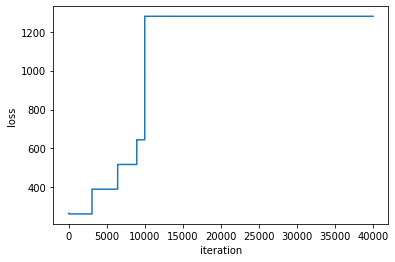

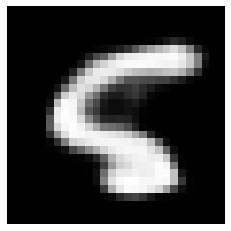

hessian postive definite
progress in % 50.0
lrate 0.1
iter 0 loss 271.25385 inverse T 0.2
iter 1000 loss 264.16162 inverse T 0.2
iter 2000 loss 264.16418 inverse T 0.2
iter 3000 loss 264.15945 inverse T 0.2
iter 4000 loss 391.92102 inverse T 0.3
iter 5000 loss 391.9136 inverse T 0.3
iter 6000 loss 391.9224 inverse T 0.3
iter 7000 loss 519.64215 inverse T 0.4
iter 8000 loss 519.6785 inverse T 0.4
iter 9000 loss 647.3656 inverse T 0.5
lrate 0.01
iter 0 loss 1285.8131 inverse T 1.0
iter 1000 loss 1285.7025 inverse T 1.0
iter 2000 loss 1285.7058 inverse T 1.0
iter 3000 loss 1285.7056 inverse T 1.0
iter 4000 loss 1285.7037 inverse T 1.0
iter 5000 loss 1285.7028 inverse T 1.0
iter 6000 loss 1285.7019 inverse T 1.0
iter 7000 loss 1285.7023 inverse T 1.0
iter 8000 loss 1285.7036 inverse T 1.0
iter 9000 loss 1285.7019 inverse T 1.0
lrate 0.001
iter 0 loss 1285.7032 inverse T 1.0
iter 1000 loss 1285.7007 inverse T 1.0
iter 2000 loss 1285.7006 inverse T 1.0
iter 3000 loss 1285.7007 inverse T 1.0


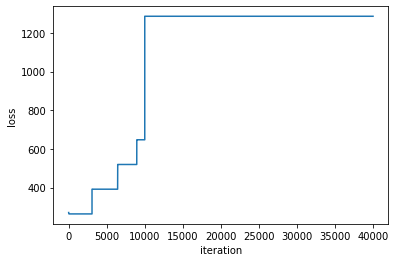

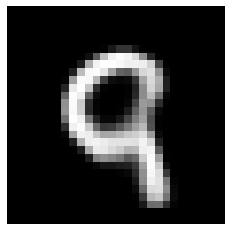

hessian postive definite
progress in % 60.0
lrate 0.1
iter 0 loss 272.73502 inverse T 0.2
iter 1000 loss 263.21558 inverse T 0.2
iter 2000 loss 263.2035 inverse T 0.2
iter 3000 loss 263.20303 inverse T 0.2
iter 4000 loss 390.32257 inverse T 0.3
iter 5000 loss 390.35022 inverse T 0.3
iter 6000 loss 390.3548 inverse T 0.3
iter 7000 loss 517.39996 inverse T 0.4
iter 8000 loss 517.41864 inverse T 0.4
iter 9000 loss 644.4669 inverse T 0.5
lrate 0.01
iter 0 loss 1279.6149 inverse T 1.0
iter 1000 loss 1279.2766 inverse T 1.0
iter 2000 loss 1279.2745 inverse T 1.0
iter 3000 loss 1279.2747 inverse T 1.0
iter 4000 loss 1279.275 inverse T 1.0
iter 5000 loss 1279.2712 inverse T 1.0
iter 6000 loss 1279.272 inverse T 1.0
iter 7000 loss 1279.2698 inverse T 1.0
iter 8000 loss 1279.2832 inverse T 1.0
iter 9000 loss 1279.2699 inverse T 1.0
lrate 0.001
iter 0 loss 1279.2714 inverse T 1.0
iter 1000 loss 1279.2683 inverse T 1.0
iter 2000 loss 1279.2686 inverse T 1.0
iter 3000 loss 1279.2681 inverse T 1.0
i

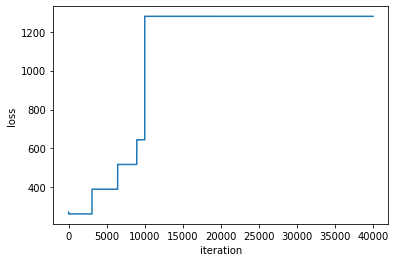

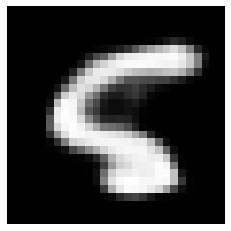

hessian postive definite
progress in % 70.0
lrate 0.1
iter 0 loss 271.87173 inverse T 0.2
iter 1000 loss 263.20282 inverse T 0.2
iter 2000 loss 263.20578 inverse T 0.2
iter 3000 loss 263.21118 inverse T 0.2
iter 4000 loss 390.35226 inverse T 0.3
iter 5000 loss 390.34192 inverse T 0.3
iter 6000 loss 390.35785 inverse T 0.3
iter 7000 loss 517.4893 inverse T 0.4
iter 8000 loss 517.4237 inverse T 0.4
iter 9000 loss 644.4661 inverse T 0.5
lrate 0.01
iter 0 loss 1279.571 inverse T 1.0
iter 1000 loss 1279.3912 inverse T 1.0
iter 2000 loss 1279.3892 inverse T 1.0
iter 3000 loss 1279.3878 inverse T 1.0
iter 4000 loss 1279.3882 inverse T 1.0
iter 5000 loss 1279.3876 inverse T 1.0
iter 6000 loss 1279.389 inverse T 1.0
iter 7000 loss 1279.388 inverse T 1.0
iter 8000 loss 1279.3895 inverse T 1.0
iter 9000 loss 1279.3878 inverse T 1.0
lrate 0.001
iter 0 loss 1279.3873 inverse T 1.0
iter 1000 loss 1279.3865 inverse T 1.0
iter 2000 loss 1279.3868 inverse T 1.0
iter 3000 loss 1279.3865 inverse T 1.0
it

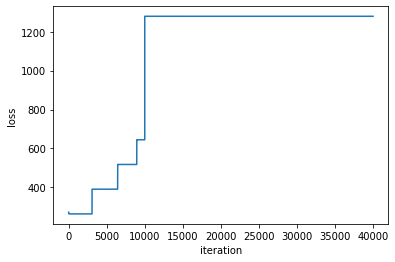

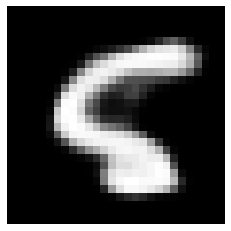

hessian postive definite
progress in % 80.0
lrate 0.1
iter 0 loss 270.80997 inverse T 0.2
iter 1000 loss 263.20306 inverse T 0.2
iter 2000 loss 263.2035 inverse T 0.2
iter 3000 loss 263.2053 inverse T 0.2
iter 4000 loss 390.32602 inverse T 0.3
iter 5000 loss 390.40826 inverse T 0.3
iter 6000 loss 390.33746 inverse T 0.3
iter 7000 loss 517.407 inverse T 0.4
iter 8000 loss 517.426 inverse T 0.4
iter 9000 loss 644.5329 inverse T 0.5
lrate 0.01
iter 0 loss 1279.5481 inverse T 1.0
iter 1000 loss 1279.4352 inverse T 1.0
iter 2000 loss 1279.4353 inverse T 1.0
iter 3000 loss 1279.4377 inverse T 1.0
iter 4000 loss 1279.4363 inverse T 1.0
iter 5000 loss 1279.4374 inverse T 1.0
iter 6000 loss 1279.4384 inverse T 1.0
iter 7000 loss 1279.3868 inverse T 1.0
iter 8000 loss 1279.3898 inverse T 1.0
iter 9000 loss 1279.3873 inverse T 1.0
lrate 0.001
iter 0 loss 1279.3889 inverse T 1.0
iter 1000 loss 1279.3865 inverse T 1.0
iter 2000 loss 1279.3864 inverse T 1.0
iter 3000 loss 1279.3862 inverse T 1.0
ite

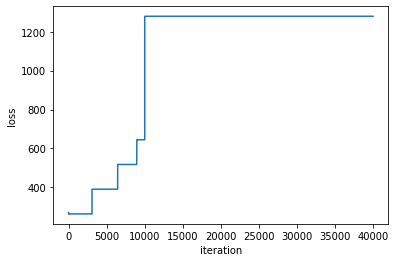

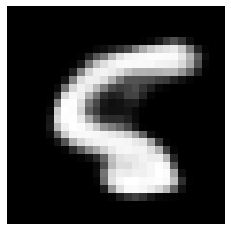

hessian postive definite
progress in % 90.0
lrate 0.1
iter 0 loss 274.1624 inverse T 0.2
iter 1000 loss 264.30106 inverse T 0.2
iter 2000 loss 264.31146 inverse T 0.2
iter 3000 loss 264.33087 inverse T 0.2
iter 4000 loss 392.31262 inverse T 0.3
iter 5000 loss 392.28073 inverse T 0.3
iter 6000 loss 392.27454 inverse T 0.3
iter 7000 loss 520.27655 inverse T 0.4
iter 8000 loss 520.2915 inverse T 0.4
iter 9000 loss 648.2217 inverse T 0.5
lrate 0.01
iter 0 loss 1287.911 inverse T 1.0
iter 1000 loss 1287.8556 inverse T 1.0
iter 2000 loss 1287.8553 inverse T 1.0
iter 3000 loss 1287.8544 inverse T 1.0
iter 4000 loss 1287.8541 inverse T 1.0
iter 5000 loss 1287.8601 inverse T 1.0
iter 6000 loss 1287.8535 inverse T 1.0
iter 7000 loss 1287.8557 inverse T 1.0
iter 8000 loss 1287.8572 inverse T 1.0
iter 9000 loss 1287.8556 inverse T 1.0
lrate 0.001
iter 0 loss 1287.856 inverse T 1.0
iter 1000 loss 1287.8518 inverse T 1.0
iter 2000 loss 1287.852 inverse T 1.0
iter 3000 loss 1287.8512 inverse T 1.0
it

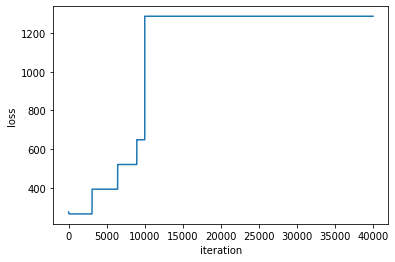

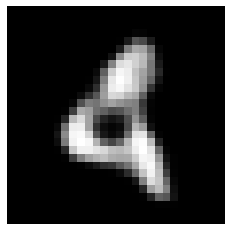

hessian postive definite


In [52]:
if __name__ == "__main__":
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  plot_path = params['plot_dir']
  
  truth = x_test[num_mnist:num_mnist+data_size]
  plot_image(truth[0], directory=plot_path, filename='truth_%s'%label, title='truth')
  print(corr_type, truth.shape)
  data, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
  print(data.shape)
  plot_image(data[0], directory=plot_path, filename='input_data_%s'%label, title='data')
  plot_image(custom_mask, directory=plot_path, filename='mask_data_%s'%label, title='mask')
  
  noise = get_custom_noise(data.shape, signal_dependent=False, signal=truth)
  plot_image(noise[0], directory=plot_path, filename='noise_%s'%label, title='noise')
  
  data = np.reshape(data,(-1,28*28,1))
  custom_mask = np.reshape(custom_mask,(28*28))
  noise = np.sqrt(noise_n**2+noise_level**2)
  
  tf.random.set_random_seed(seed)
  inits = get_random_start_values(10, sess)

  try:
    minima, min_loss, min_var,recons, hesss, hesssGN = pickle.load(open(minima_path+'minima_%s.pkl'%label,'rb'))
  except:
  
    minima  =[]
    min_loss=[]
    min_var =[]
    recons  =[]
    hesss   =[]
    hesssGN =[]
    for jj,init in enumerate(inits):
      print('progress in %', jj/len(inits)*100)
      min_z, min_l, pos_def,hess,hessGN    = minimize_posterior(init, data,custom_mask,noise,sess)
      rec                           = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
      var                           = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  
      plot_image(rec[0], directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
      if pos_def:
        print('hessian postive definite')
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)
        hesss.append(hess)
        hesssGN.append(hessGN)
    
    order    = np.argsort(min_loss)
    min_loss = np.asarray(min_loss)[order]
    minima   = np.asarray(minima)[order]
    min_var  = np.asarray(min_var)[order]
    hesss    = np.asarray(hesss)[order]
    hesssGN  = np.asarray(hesssGN)[order]
    
    pickle.dump([minima, min_loss, min_var,recons, hesss, hesssGN],open(minima_path+'minima_%s.pkl'%label,'wb'))

#   lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0]})
#   rec     = sess.run(recon_MAP, feed_dict={MAP_ini:minima[0],sigma_corr:noise})
#   plot_image(rec[0]+0.5, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)
#   if corr_type in ['mask', 'sparse mask', 'noise+mask']:
#     plot_image(rec[0]+0.5, directory=plot_path, filename='lowest_minimum_%s_masked'%(label), title='masked reconstruction', vmin=0, vmax=1, mask = custom_mask)
    
#   samples  = sess.run(posterior_sample, feed_dict={MAP_ini:minima[0],input_data: data,sigma_corr:noise})
#   print(np.std(samples-minima[0][0]))
#   recs     = sess.run(recon_MAP, feed_dict={MAP_ini:samples, sigma_corr:noise,input_data: data,sigma_corr:noise})
#   #plot_samples(recs+0.5, custom_mask, title='Samples from Laplace approximation', filename='samples_laplace_deepest_minimum_%s'%label)
#   for ii in range(16):
#     plt.subplot(4,4,ii+1)
#     plt.imshow((recs[ii]+0.5).reshape(28,28),cmap='gray')
#     plt.axis('off')
#   mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[1]], data, noise, custom_mask, min_loss[0])
#   print(sigma_,mu_,w_)
#   _ = sess.run([update_w, update_mugmm,update_TriLgmm], feed_dict={mu_ini:mu_, w_ini:w_, sigma_ini:sigma_ })

#   samples = get_gmm_sample(16,data,custom_mask,noise,sess)
#   plot_samples(samples[:,0:1,:,:]+0.5, custom_mask, title='GMM samples', filename='gmm_samples_%s'%label)
  
# #   more_samples = []
# #   for ii in range(10000):
# #     more_samples+=[sess.run(gmm_sample,feed_dict={input_data: data, sigma_corr:noise})]
# #   more_samples=np.asarray(more_samples)
  
# #   for indices in [[0,1],[1,2],[3,8]]:
# #     plot_prob_2D_GMM(more_samples, indices)
  

In [59]:
len(min_loss)

10

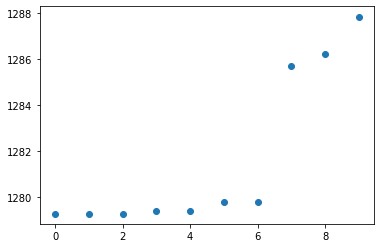

In [60]:
plt.scatter(np.arange(len(min_loss)),min_loss)

[1.76601340e-01 6.25907314e-01 1.95869692e-01 3.43590074e-04
 4.11193671e-04 8.66870924e-04]


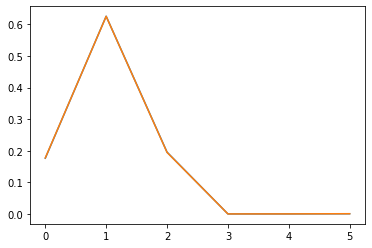

In [61]:
w=[]
for ii in [0,3,5,7,8,9]:
    hess    = hesss[ii]
    cov     = np.linalg.inv(hess)
    _, logdet = np.linalg.slogdet(cov)
    logprob   = -min_loss[ii]
    #print(logprob,logdet)
    w+=[np.exp(0.5*logdet+logprob+900)]
w=np.asarray(w)/np.sum(np.asarray(w))
plt.plot(w)
print(w)
index_gauss =np.sum(np.random.multinomial(1, w,500000),axis=0)
_=plt.plot(index_gauss/500000)

samples = []
for ii, n in enumerate([0,3,5,7,8,9]):
    for jj in range(index_gauss[ii]):
        cov = np.linalg.inv(hesss[n])
        samples.append(np.dot(np.linalg.cholesky(cov),np.random.randn(8))+minima[n][0])
samples=np.asarray(samples)

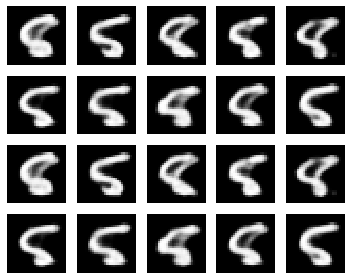

In [62]:
ii       = 0
recs     = sess.run(MAP_reset, feed_dict={MAP_ini:samples[ii:ii+64], sigma_corr:noise,input_data: data,sigma_corr:noise})
recs     = sess.run(recon_MAP, feed_dict={MAP_ini:samples[ii:ii+64], sigma_corr:noise,input_data: data,sigma_corr:noise})

recs     = np.reshape(recs,(-1,28,28))+0.5
  #plot_samples(recs+0.5, custom_mask, title='Samples from Laplace approximation', filename='samples_laplace_deepest_minimum_%s'%label)
plt.figure(figsize=(5,4))
for ii in range(10):
    plt.subplot(4,5,ii+1)
    plt.imshow((recs[ii]).reshape(28,28),cmap='gray')
    plt.axis('off')
for ii in range(10):
    plt.subplot(4,5,10+ii+1)
    masked = recs[ii]
    masked[np.where(custom_mask.reshape(28,28)==0)]=0
    plt.imshow(masked,cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(params['plot_dir']+'posterior_samples_example1.pdf'),bbox_inches='tight')


# plt.figure(figsize=(5,5))
# for ii in range(32):
#     plt.subplot(8,8,ii+1)

#     plt.axis('off')
#     plt.tight_layout()
# plt.savefig(os.path.join(params['plot_dir']+'posterior_samples_maksed_example1.pdf'),bbox_inches='tight')

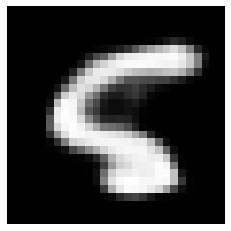

True

In [63]:
recs     = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0], sigma_corr:noise,input_data: data,sigma_corr:noise})
recs     = sess.run(recon_MAP, feed_dict={MAP_ini:minima[0], sigma_corr:noise,input_data: data,sigma_corr:noise})
plot_image(recs[0], directory=plot_path, filename='reconstruction', title='reconstruction')

In [64]:
from mcmcplot import mcmcplot as mcp

In [65]:
samples_cut=np.vstack((samples[:,0],samples[:,1])).T
samples_cut.shape

(500000, 2)

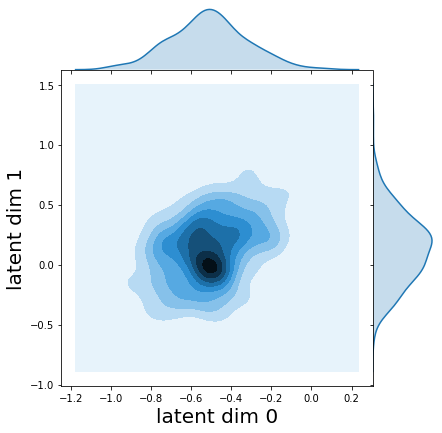

In [66]:
fjd, used_settings = mcp.plot_joint_distributions(
    chains=samples_cut,names=['latent dim 0', 'latent dim 1'],
    settings=None,
    return_settings=True)
a = fjd.ax_joint
tmp = a.yaxis.get_label()
tmp.set_fontsize(20)
tmp = a.xaxis.get_label()
tmp.set_fontsize(20)
plt.savefig(os.path.join(params['plot_dir']+'distribution.pdf'),bbox_inches='tight')